In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats
import os
%matplotlib inline

In [3]:
# #fix all seeds for random number generators
# # Set seed value
# seed_value = 9
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
# random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# #TODO need to initiate session here on tensorflow to fix random seeds

In [27]:
#Params

mdlname = 'saved_model/cnn3v20'
mdl_paramsfn = 'depthforcemodelparam_cnn3v20_pb.pkl'
# datapath = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo"
datapath = r'C:\Users\Alex\Box Sync\CS598 - Final Project\Preliminary Data V5\Test_Subject_Leo'

In [5]:
# def create_model():
    
#     from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
#     from tensorflow.keras.layers import BatchNormalization
#     from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
#     from tensorflow.keras.models import Model
#     dropout_rate = 0.2

#     model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
#     model_start2 = Input(shape=(xfcss_train.shape[1],))
#     model_cnn = model_start
#     model_perc = model_start2

#     model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_perc = Dense(100)(model_perc)
#     model_perc = Activation('relu')(model_perc)

#     model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_perc = Dense(100)(model_perc)
#     model_perc = Activation('relu')(model_perc)

#     model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_cnn = Flatten()(model_cnn)


#     model_cnn = Dense(128)(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
# #     model_cnn = Dropout(dropout_rate)(model_cnn)

#     model_comb = concatenate([model_cnn,model_perc],axis=-1)

#     model_comb = Dense(100)(model_comb)
#     model_comb = Activation('relu')(model_comb)
#     model_comb = Dropout(dropout_rate)(model_comb)

#     output = Dense(1)(model_comb)
#     output = Activation('linear', name='thetaz_out')(output)
#     model = Model(inputs=[model_start,model_start2],outputs=output)
    
#     return model
    
    

In [28]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret:
            frame = frame/255
            frame = cv2.resize(frame, \
                               (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                               interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = frame
            
            count = count + 1
        else: 
            break
    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data
        

In [29]:
# Read in Input Data 
#TODO clean up this section of code for easy access from other computers
n_test = (24,30,31,32,33,35)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    data_dir = os.path.join(datapath, test_str)
    train_dcamera_path = os.path.join(data_dir,'depth_processed_leo_test'+str(n_test[i])+'.avi')
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train
    

tlen = len(xtemp[0]) +len(xtemp[1])+len(xtemp[2])+len(xtemp[3])+len(xtemp[4])+len(xtemp[5]) #remove 2 samples from 24 and 3 from 25
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
xrun = len(xtemp[0])
x_train[:xrun,:,:,:] = xtemp[0][:xrun,:,:,:]
xrun1 = xrun + len(xtemp[1])
x_train[xrun:xrun1,:,:,:]=xtemp[1][:xrun1-xrun,:,:,:]
xrun2 = xrun1 + len(xtemp[2])
x_train[xrun1:xrun2,:,:,:] = xtemp[2][:xrun2-xrun1,:,:,:]
xrun3 = xrun2 + len(xtemp[3])
x_train[xrun2:xrun3,:,:,:] = xtemp[3][:xrun3-xrun2,:,:,:]
xrun4 = xrun3 + len(xtemp[4])
x_train[xrun3:xrun4,:,:,:] = xtemp[4][:xrun4-xrun3,:,:,:]
xrun5 = xrun4 + len(xtemp[5])
x_train[xrun4:xrun5,:,:,:] = xtemp[5][:xrun5-xrun4,:,:,:]
del xtemp

## Read Input Data: FCSS
n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    data_dir = os.path.join(datapath, test_str)
    fcss_data_dir = os.path.join(data_dir,"fcss_processed_leo_" + test_str + '_' + date[i] + '.txt')
    xfcss_gttemp = pd.read_csv(fcss_data_dir)
    xfcss_gt[i]=xfcss_gttemp
    xfcss_gt[i]['weight'] = 67# hacky but will work for now
    xfcss_gt[i]['height'] = 174# hacky but will work for now
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [30]:
train_dcamera_path

'C:\\Users\\Alex\\Box Sync\\CS598 - Final Project\\Preliminary Data V5\\Test_Subject_Leo\\test35\\depth_processed_leo_test35.avi'

In [31]:
# Read in Output Data 
#TODO clean up this section of code for easy access from other computers
n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    data_dir = os.path.join(datapath, test_str)
    qtm_file_data_dir = os.path.join(data_dir, 'qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt')
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
y_train = np.zeros((tlen,1))
xrun = len(y_gt[0])
y_train[:xrun] = y_gt[0][:xrun]
xrun1 = xrun + len(y_gt[1])
y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
xrun2 = xrun1 + len(y_gt[2])
y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
xrun3 = xrun2 + len(y_gt[3])
y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
xrun4 = xrun3 + len(y_gt[4])
y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
xrun5 = xrun4 + len(y_gt[5])
y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]
del y_gt

In [32]:
## Saturate output
def saturate(theta, min_val, max_val):
    for i in range(len(theta)):
        if theta[i] < min_val:
            theta[i] = min_val
            continue
        if theta[i] > max_val:
            theta[i] = max_val
            continue
    return theta
            
min_val = -50
max_val = 50
    
y_train = saturate(y_train, min_val, max_val)

In [33]:
load_prevset = 1# (1): load previously trained Nnet Regression Model (0): Create new Nnet Regression Model to train
ranold = 0

if load_prevset:
    
    with open(mdl_paramsfn, 'rb') as file:
        mdl_prm = pickle.load(file)
    
    randata=mdl_prm[0]
    sc_y=mdl_prm[1]
    sc_X2 = mdl_prm[2]
    modelhistory=mdl_prm[3]
    if ranold:
        nsamps = randata['nsamps']
        n80p = randata['n80p']
        rannums = randata['rannums']
        test_set = randata['test_set']
else:
    nsamps = x_train.shape[0]
    n80p = int(np.floor(nsamps*0.8))
    rannums = np.array(random.sample(range(1,nsamps,1), n80p))
    s_nfiles = np.arange(nsamps)
    test_set = np.setdiff1d(s_nfiles,rannums)
    sc_y = StandardScaler()
    sc_X2 = StandardScaler()

Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = sc_y.fit_transform(ytrainz)
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = sc_y.transform(y_valid)

In [34]:
def load_mdl(mdlname):
#     model=create_model()
#     modelname = mdlname
#     model.load_weights(modelname)
    model = tf.keras.models.load_model(mdlname)
    return model

In [35]:
model = load_mdl(mdlname)

In [14]:
# import keras
# import pydot
# import pydotplus
# from keras.utils.vis_utils import model_to_dot
# keras.utils.vis_utils.pydot = pydot
# keras.utils.plot_model(model, to_file='model.png')

In [36]:
# tf.keras.utils.plot_model(model, to_file='model.png',rankdir='TB',show_shapes=False,expand_nested=True)

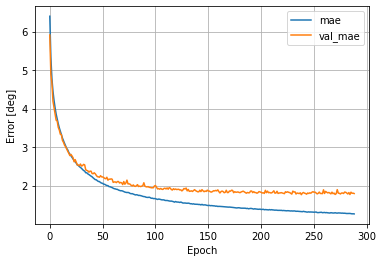

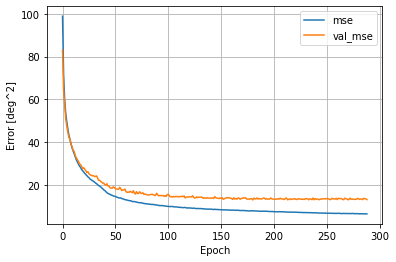

In [37]:
def plot_loss(history):
    
    v1 = history['mae']*np.sqrt(sc_y.var_)
    v2 = history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history['mse']*sc_y.var_
    v4 = history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(modelhistory)


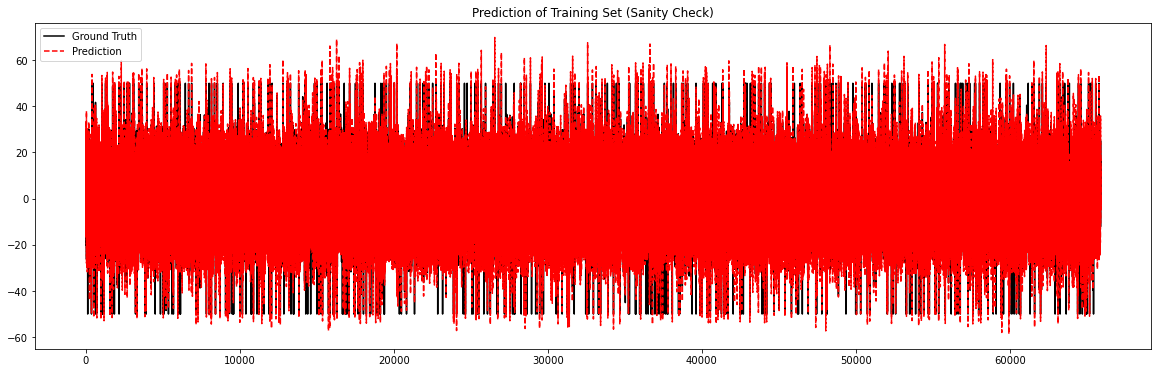

Average error is 0.00 degrees
Root Mean Squared Error is 3.07 degrees
Mean Absolute Error is 3.07 degrees


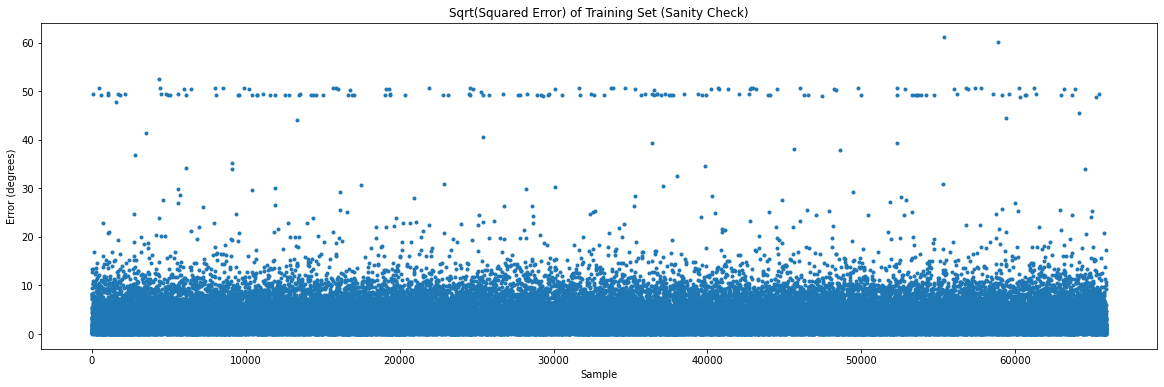

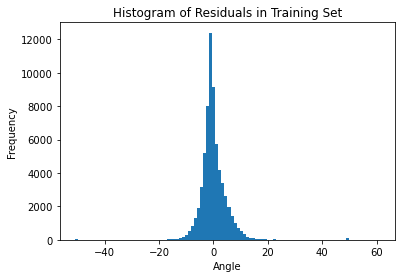

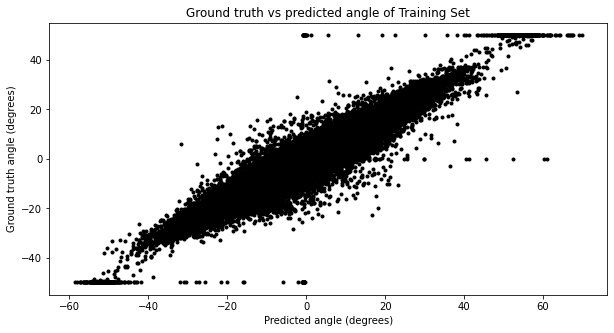

In [38]:

# sanity check with 80% data

Xtrainz = Trainset
Xtrainz2 = sc_X2.transform(Trainset2)
y_pred = model.predict([Xtrainz,Xtrainz2])
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy


plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

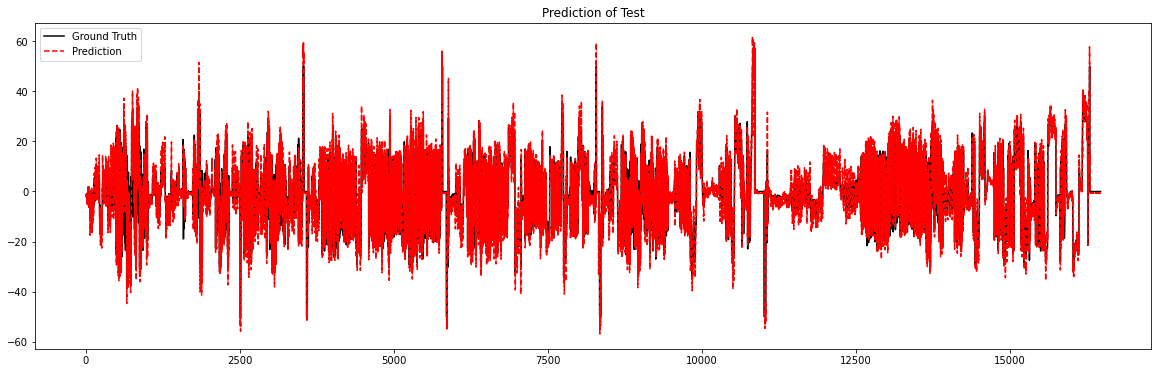

Average error is -0.01 degrees
Root Mean Squared Error is 3.04 degrees
Mean Absolute Error is 3.04 degrees


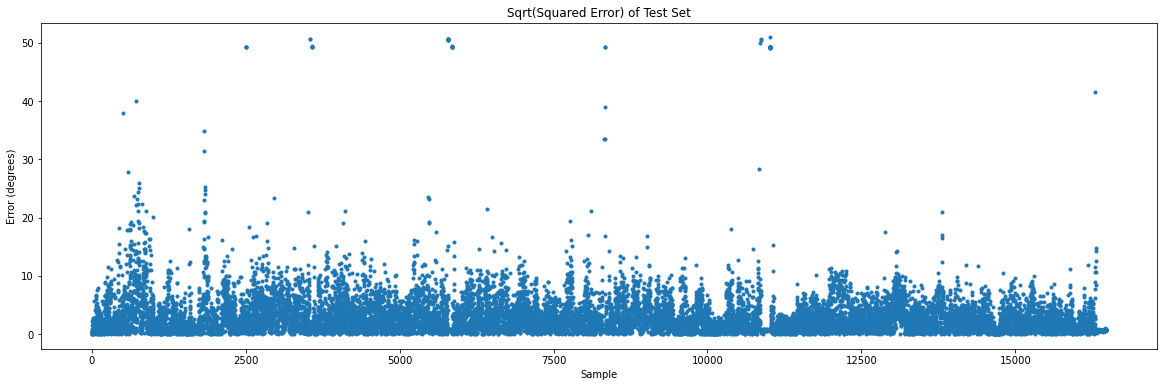

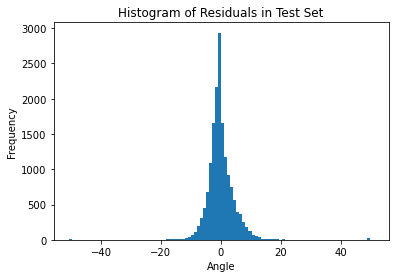

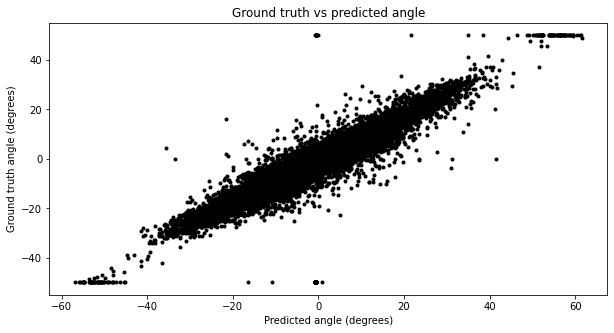

In [39]:
# Redo test set
Xtest = Testset
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy



plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [26]:
loss, mse_std, mae_std = model.evaluate([Xtest,Xtest2], sc_y.transform(y_new), verbose=2)
mae = mae_std*sc_y.var_[0]**0.5
print('Restored model, accuracy: {:5.2f} degrees'.format(mae))

515/515 - 11s - loss: 0.2087 - mean_squared_error: 0.1240 - mean_absolute_error: 0.2087
Restored model, accuracy:  2.62 degrees


In [46]:
%matplotlib qt

In [47]:
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))


Average error is -0.01 degrees
Root Mean Squared Error is 3.04 degrees
Mean Absolute Error is 3.04 degrees
